In [1]:
import pandas as pd
from pulp import LpMaximize, LpProblem, LpVariable, lpSum, LpBinary, LpStatus, PULP_CBC_CMD
from scipy.cluster.hierarchy import dendrogram, linkage,fcluster
import matplotlib.pyplot as plt
#from espn_api.football import League
#league = League(league_id=2113531198, year=2023, espn_s2='AEBGNcTtIkyeEgBLljv3A9BVG7xE1%2FQyCbXQvBF6NvSjCqdguy4VmCidrifavjN0KVMUahU27mtwAWARKz%2F6thmI2ZW1hP%2BlUeht9mLHWBnd8kz7fXCiw50KlbDNk4cCXaBn38v6TWpMaWXMV9C17Egs8g3WxjyOlCvEZKrkbq2yyf%2BltGPH%2BBQ5zp3MdB1MK6K12IazGncWBXEJvqrDtgq0J2Eb3ylEfMsSlGu2dFWXhGTl1uhPX%2F5Uh4Yehp0lJO7L8kl65Uq4QZcwFYZGZSJQ0qIg6Buj0osFQbjnm1yR2g%3D%3D', swid='{BF591EE3-B954-4E70-991E-E3B9544E7031}')

# read in fantasypros stat projections and adp
qbproj = pd.read_csv('/Users/zachwayne/Documents/Github/Fantasy-Football-Optimizer/FantasyProsData/FantasyPros_Fantasy_Football_Projections_QB.csv')
rbproj =  pd.read_csv('/Users/zachwayne/Documents/Github/Fantasy-Football-Optimizer/FantasyProsData/FantasyPros_Fantasy_Football_Projections_RB.csv')
wrproj =  pd.read_csv('/Users/zachwayne/Documents/Github/Fantasy-Football-Optimizer/FantasyProsData/FantasyPros_Fantasy_Football_Projections_WR.csv')
teproj = pd.read_csv('/Users/zachwayne/Documents/Github/Fantasy-Football-Optimizer/FantasyProsData/FantasyPros_Fantasy_Football_Projections_TE.csv')
kproj = pd.read_csv('/Users/zachwayne/Documents/Github/Fantasy-Football-Optimizer/FantasyProsData/FantasyPros_Fantasy_Football_Projections_K.csv')
dstproj = pd.read_csv('/Users/zachwayne/Documents/Github/Fantasy-Football-Optimizer/FantasyProsData/FantasyPros_Fantasy_Football_Projections_DST.csv')
adp = pd.read_csv('/Users/zachwayne/Documents/Github/Fantasy-Football-Optimizer/FantasyProsData/FantasyPros_2023_Overall_ADP_Rankings.csv')

In [2]:
#### SCORING SYSTEM ####
passing_yards = 1/25
passing_tds = 6
passing_ints = -2
rushing_yards = 1/10
rushing_tds = 6
receiving_yards = 1/10
receiving_tds = 6
receptions = .5

In [3]:
# convert YDS, which is an object, to float by removing commas 
# do this only do the columns that need it
# in this case, a QB is projected to have >1k rushing yards, but not other positions have 
# a player projected to have >1k yards in their non-primary position
qbproj['YDS'] = qbproj['YDS'].str.replace(',', '').astype(float)
qbproj['YDS.1'] = qbproj['YDS.1'].str.replace(',', '').astype(float)
rbproj['YDS'] = rbproj['YDS'].str.replace(',', '').astype(float)
wrproj['YDS'] = wrproj['YDS'].str.replace(',', '').astype(float)
teproj['YDS'] = teproj['YDS'].str.replace(',', '').astype(float)

In [4]:
# use the stats projections to calculate the total projected fantasy points for each player using the scoring system
qbproj['Projection'] = qbproj['YDS'] * passing_yards + qbproj['TDS'] * passing_tds + qbproj['INTS'] * passing_ints + qbproj['YDS.1'] * rushing_yards + qbproj['TDS.1'] * rushing_tds
qbproj["Pos"] = "QB"
qbproj = qbproj[['Player', 'Projection', 'Pos']]

rbproj['Projection'] = rbproj['YDS'] * rushing_yards + rbproj['TDS'] * rushing_tds + rbproj['YDS.1'] * receiving_yards + rbproj['TDS.1'] * receiving_tds + rbproj['REC'] * receptions
rbproj["Pos"] = "RB"
rbproj = rbproj[['Player', 'Projection', 'Pos']]

wrproj['Projection'] = wrproj['YDS'] * receiving_yards + wrproj['TDS'] * receiving_tds + wrproj['YDS.1'] * rushing_yards + wrproj['TDS.1'] * rushing_tds + wrproj['REC'] * receptions
wrproj["Pos"] = "WR"
wrproj = wrproj[['Player', 'Projection', 'Pos']]

teproj['Projection'] = teproj['YDS'] * receiving_yards + teproj['TDS'] * receiving_tds + teproj['REC'] * receptions
teproj["Pos"] = "TE"
teproj = teproj[['Player', 'Projection', 'Pos']]

kproj['Projection'] = kproj['FPTS']
kproj["Pos"] = "K"
kproj = kproj[['Player', 'Projection', 'Pos']]

dstproj['Projection'] = dstproj['FPTS']
dstproj["Pos"] = "DST"
dstproj = dstproj[['Player', 'Projection', 'Pos']]

In [5]:
# combine all projections into one dataframe
proj = pd.concat([qbproj, rbproj, wrproj, teproj, kproj,dstproj])
# join projections with adp
df = pd.merge(proj, adp, on='Player', how='outer')
# delete any rows with NaN in the Rank column or projection column
df = df.dropna(subset=['Rank', 'Projection'])
# create a column that ranks each player by position based on their projection
df['pos_rank'] = df.groupby('Pos')['Projection'].rank(ascending=False)
df = df[['Player', 'Projection', 'Pos', 'Rank', 'pos_rank']]

### Clustering for tiers

#### QB ####

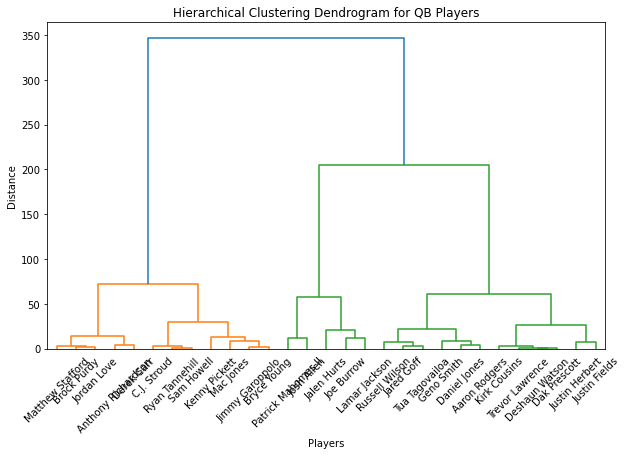

In [6]:
# QB clustering
pos_df = df[df['Pos'] == 'QB']
# take the top 30 QBs
pos_df = pos_df[pos_df['pos_rank'] < 30]
# make the pos_rank the index and sort by it - this makes players appear in tiers in order
pos_df.index = pos_df['pos_rank']
pos_df = pos_df.sort_index()
# create a dendrogram
X = pos_df[['Projection']]
linkage_matrix = linkage(X, method='ward')
plt.figure(figsize=(10, 6))
dendrogram(linkage_matrix, labels=pos_df['Player'].tolist(), orientation='top', leaf_font_size=10)
plt.title('Hierarchical Clustering Dendrogram for QB Players')
plt.xlabel('Players')
plt.ylabel('Distance')
plt.show()

In [7]:
# use the dendrogram to determine the number of clusters
num_clusters = 7
clusters = fcluster(linkage_matrix, num_clusters, criterion='maxclust')

# Add a 'Cluster' column to the DataFrame
pos_df['Cluster'] = clusters

# find the cluster average projection for each cluster
cluster_avg_projections = pos_df.groupby('Cluster')['Projection'].mean().reset_index()
# sort the clusters by average projection
cluster_avg_projections = cluster_avg_projections.sort_values(by='Projection', ascending=False)

# Create a dictionary to map old cluster numbers to new cluster numbers - i.e. 1 being the top tier, etc.
new_cluster_numbers = {old_cluster: idx + 1 for idx, old_cluster in enumerate(cluster_avg_projections['Cluster'])}

# Update the 'Cluster' column with the new cluster numbers
pos_df['Cluster'] = pos_df['Cluster'].map(new_cluster_numbers)

# add cluster to df for each player
for player in pos_df['Player']:
    df.loc[df['Player'] == player, 'Cluster'] = pos_df.loc[pos_df['Player'] == player, 'Cluster'].values[0]

# print the clusters out for inspection - can rerun this cell to see different clusters
for cluster_num in range(1, num_clusters + 1):
    cluster_group = pos_df[pos_df['Cluster'] == cluster_num]
    print(f'Cluster {cluster_num}:')
    print(cluster_group[['Player', 'Projection']])
    print()


Cluster 1:
                      Player  Projection
pos_rank                                
1.0       Patrick Mahomes II     452.320
2.0               Josh Allen     440.026

Cluster 2:
                 Player  Projection
pos_rank                           
3.0         Jalen Hurts     421.014
4.0          Joe Burrow     408.394
5.0       Lamar Jackson     397.002

Cluster 3:
                   Player  Projection
pos_rank                             
6.0        Justin Herbert     373.328
7.0         Justin Fields     366.066
8.0          Kirk Cousins     355.288
9.0        Deshaun Watson     353.664
10.0         Dak Prescott     353.328
11.0      Trevor Lawrence     352.668

Cluster 4:
                  Player  Projection
pos_rank                            
12.0          Geno Smith     345.588
13.0        Daniel Jones     340.364
14.0       Aaron Rodgers     336.008
15.0          Jared Goff     331.710
16.0      Tua Tagovailoa     328.344
17.0      Russell Wilson     323.928

Cluster 

#### RB ####

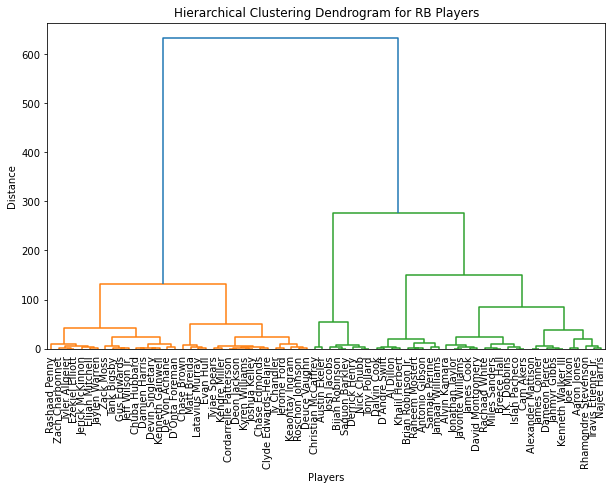

In [8]:
pos_df = df[df['Pos'] == 'RB']
pos_df.index = pos_df['pos_rank']
pos_df = pos_df[pos_df['pos_rank'] <= 72]
pos_df = pos_df.sort_index()
X = pos_df[['Projection']]
linkage_matrix = linkage(X, method='ward')
plt.figure(figsize=(10, 6))
dendrogram(linkage_matrix, labels=pos_df['Player'].tolist(), orientation='top', leaf_font_size=10)
plt.title('Hierarchical Clustering Dendrogram for RB Players')
plt.xlabel('Players')
plt.ylabel('Distance')
plt.show()

In [9]:
num_clusters = 10
clusters = fcluster(linkage_matrix, num_clusters, criterion='maxclust')

# Add a 'Cluster' column to the DataFrame
pos_df['Cluster'] = clusters

# find the cluster with the highest average projection and reorganize the clusters based on that
# Calculate the average projection for each cluster
cluster_avg_projections = pos_df.groupby('Cluster')['Projection'].mean().reset_index()

# Sort the clusters by average projection in descending order
cluster_avg_projections = cluster_avg_projections.sort_values(by='Projection', ascending=False)

# Create a dictionary to map old cluster numbers to new cluster numbers
new_cluster_numbers = {old_cluster: idx + 1 for idx, old_cluster in enumerate(cluster_avg_projections['Cluster'])}

# Update the 'Cluster' column with the new cluster numbers
pos_df['Cluster'] = pos_df['Cluster'].map(new_cluster_numbers)

# add cluster to df for each player
for player in pos_df['Player']:
    df.loc[df['Player'] == player, 'Cluster'] = pos_df.loc[pos_df['Player'] == player, 'Cluster'].values[0]

for cluster_num in range(1, num_clusters + 1):
    cluster_group = pos_df[pos_df['Cluster'] == cluster_num]
    print(f'Cluster {cluster_num}:')
    print(cluster_group[['Player', 'Projection']])
    print()



Cluster 1:
                       Player  Projection
pos_rank                                 
1.0       Christian McCaffrey      273.62
2.0             Austin Ekeler      271.16

Cluster 2:
                  Player  Projection
pos_rank                            
3.0        Derrick Henry      245.81
4.0           Nick Chubb      242.89
5.0         Tony Pollard      242.78
6.0       Bijan Robinson      239.83
7.0       Saquon Barkley      239.60
8.0          Josh Jacobs      237.62

Cluster 3:
                       Player  Projection
pos_rank                                 
9.0                 Joe Mixon      215.43
10.0              Aaron Jones      213.37
11.0      Rhamondre Stevenson      204.59
12.0       Travis Etienne Jr.      200.45
13.0             Najee Harris      199.76

Cluster 4:
                      Player  Projection
pos_rank                                
14.0      Alexander Mattison      191.44
15.0            James Conner      191.42
16.0           Dameon Pierce   

#### TE ####

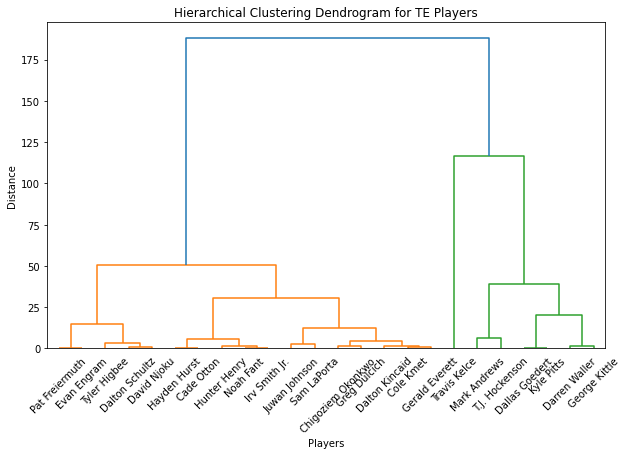

In [10]:
pos_df = df[df['Pos'] == 'TE']
pos_df.index = pos_df['pos_rank']
pos_df = pos_df[pos_df['pos_rank'] <= 24]
pos_df = pos_df.sort_index()
X = pos_df[['Projection']]
linkage_matrix = linkage(X, method='ward')
plt.figure(figsize=(10, 6))
dendrogram(linkage_matrix, labels=pos_df['Player'].tolist(), orientation='top', leaf_font_size=10)
plt.title('Hierarchical Clustering Dendrogram for TE Players')
plt.xlabel('Players')
plt.ylabel('Distance')
plt.show()

In [11]:
num_clusters = 7
clusters = fcluster(linkage_matrix, num_clusters, criterion='maxclust')

# Add a 'Cluster' column to the DataFrame
pos_df['Cluster'] = clusters

# find the cluster with the highest average projection and reorganize the clusters based on that
# Calculate the average projection for each cluster
cluster_avg_projections = pos_df.groupby('Cluster')['Projection'].mean().reset_index()

# Sort the clusters by average projection in descending order
cluster_avg_projections = cluster_avg_projections.sort_values(by='Projection', ascending=False)

# Create a dictionary to map old cluster numbers to new cluster numbers
new_cluster_numbers = {old_cluster: idx + 1 for idx, old_cluster in enumerate(cluster_avg_projections['Cluster'])}

# Update the 'Cluster' column with the new cluster numbers
pos_df['Cluster'] = pos_df['Cluster'].map(new_cluster_numbers)

# add cluster to df for each player
for player in pos_df['Player']:
    df.loc[df['Player'] == player, 'Cluster'] = pos_df.loc[pos_df['Player'] == player, 'Cluster'].values[0]
    
for cluster_num in range(1, num_clusters + 1):
    cluster_group = pos_df[pos_df['Cluster'] == cluster_num]
    print(f'Cluster {cluster_num}:')
    print(cluster_group[['Player', 'Projection']])
    print()



Cluster 1:
                Player  Projection
pos_rank                          
1.0       Travis Kelce      235.61

Cluster 2:
                  Player  Projection
pos_rank                            
2.0         Mark Andrews      165.51
3.0       T.J. Hockenson      159.28

Cluster 3:
                 Player  Projection
pos_rank                           
4.0       Darren Waller      146.31
5.0       George Kittle      144.75

Cluster 4:
                  Player  Projection
pos_rank                            
6.0       Dallas Goedert      131.11
7.0           Kyle Pitts      131.00

Cluster 5:
                  Player  Projection
pos_rank                            
8.0       Pat Freiermuth      118.75
9.0          Evan Engram      118.28
10.0      Dalton Schultz      110.32
11.0         David Njoku      109.72
12.0        Tyler Higbee      107.03

Cluster 6:
                     Player  Projection
pos_rank                               
13.0      Chigoziem Okonkwo      103.72
14.0 

#### WR ####

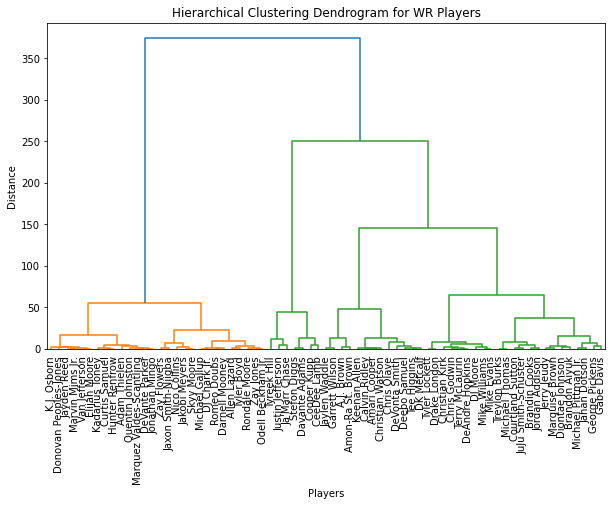

In [12]:
pos_df = df[df['Pos'] == 'WR']
pos_df.index = pos_df['pos_rank']
pos_df = pos_df[pos_df['pos_rank'] < 72]
pos_df = pos_df.sort_index()
X = pos_df[['Projection']]
linkage_matrix = linkage(X, method='ward')
plt.figure(figsize=(10, 6))
dendrogram(linkage_matrix, labels=pos_df['Player'].tolist(), orientation='top', leaf_font_size=10)
plt.title('Hierarchical Clustering Dendrogram for WR Players')
plt.xlabel('Players')
plt.ylabel('Distance')
plt.show()

In [13]:
num_clusters = 9
clusters = fcluster(linkage_matrix, num_clusters, criterion='maxclust')

# Add a 'Cluster' column to the DataFrame
pos_df['Cluster'] = clusters

# find the cluster with the highest average projection and reorganize the clusters based on that
# Calculate the average projection for each cluster
cluster_avg_projections = pos_df.groupby('Cluster')['Projection'].mean().reset_index()

# Sort the clusters by average projection in descending order
cluster_avg_projections = cluster_avg_projections.sort_values(by='Projection', ascending=False)

# Create a dictionary to map old cluster numbers to new cluster numbers
new_cluster_numbers = {old_cluster: idx + 1 for idx, old_cluster in enumerate(cluster_avg_projections['Cluster'])}

# Update the 'Cluster' column with the new cluster numbers
pos_df['Cluster'] = pos_df['Cluster'].map(new_cluster_numbers)

# add cluster to df for each player
for player in pos_df['Player']:
    df.loc[df['Player'] == player, 'Cluster'] = pos_df.loc[pos_df['Player'] == player, 'Cluster'].values[0]
    
for cluster_num in range(1, num_clusters + 1):
    cluster_group = pos_df[pos_df['Cluster'] == cluster_num]
    print(f'Cluster {cluster_num}:')
    print(cluster_group[['Player', 'Projection']])
    print()



Cluster 1:
                    Player  Projection
pos_rank                              
1.0       Justin Jefferson      262.63
2.0          Ja'Marr Chase      257.45
3.0            Tyreek Hill      249.92

Cluster 2:
                 Player  Projection
pos_rank                           
4.0         Cooper Kupp      239.79
5.0         CeeDee Lamb      235.01
6.0        Stefon Diggs      228.59
7.0       Davante Adams      227.71

Cluster 3:
                     Player  Projection
pos_rank                               
8.0              A.J. Brown      212.21
9.0       Amon-Ra St. Brown      210.51
10.0          Jaylen Waddle      202.20
11.0         Garrett Wilson      201.74

Cluster 4:
                    Player  Projection
pos_rank                              
12.0           Chris Olave      194.52
13.0           Tee Higgins      189.26
14.0            DK Metcalf      188.55
15.0          Deebo Samuel      187.65
16.0         DeVonta Smith      185.94
17.0         Calvin Ridley   

#### K ####

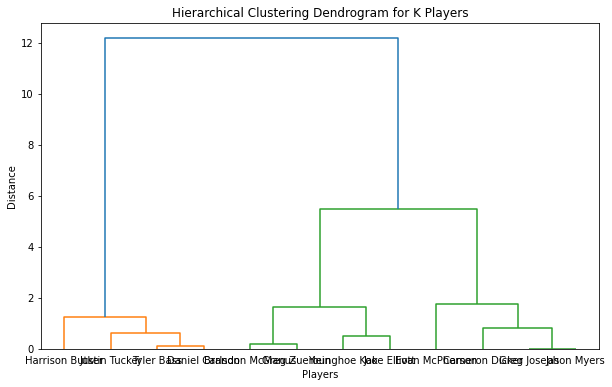

In [14]:
pos_df = df[df['Pos'] == 'K']
pos_df.index = pos_df['pos_rank']
pos_df = pos_df[pos_df['pos_rank'] <= 12]
pos_df = pos_df.sort_index()
X = pos_df[['Projection']]
linkage_matrix = linkage(X, method='ward')
plt.figure(figsize=(10, 6))
dendrogram(linkage_matrix, labels=pos_df['Player'].tolist(), orientation='top', leaf_font_size=10)
plt.title('Hierarchical Clustering Dendrogram for K Players')
plt.xlabel('Players')
plt.ylabel('Distance')
plt.show()

In [15]:
num_clusters = 3
clusters = fcluster(linkage_matrix, num_clusters, criterion='maxclust')

# Add a 'Cluster' column to the DataFrame
pos_df['Cluster'] = clusters

# find the cluster with the highest average projection and reorganize the clusters based on that
# Calculate the average projection for each cluster
cluster_avg_projections = pos_df.groupby('Cluster')['Projection'].mean().reset_index()

# Sort the clusters by average projection in descending order
cluster_avg_projections = cluster_avg_projections.sort_values(by='Projection', ascending=False)

# Create a dictionary to map old cluster numbers to new cluster numbers
new_cluster_numbers = {old_cluster: idx + 1 for idx, old_cluster in enumerate(cluster_avg_projections['Cluster'])}

# Update the 'Cluster' column with the new cluster numbers
pos_df['Cluster'] = pos_df['Cluster'].map(new_cluster_numbers)

# add cluster to df for each player
for player in pos_df['Player']:
    df.loc[df['Player'] == player, 'Cluster'] = pos_df.loc[pos_df['Player'] == player, 'Cluster'].values[0]
    
for cluster_num in range(1, num_clusters + 1):
    cluster_group = pos_df[pos_df['Cluster'] == cluster_num]
    print(f'Cluster {cluster_num}:')
    print(cluster_group[['Player', 'Projection']])
    print()


Cluster 1:
                   Player  Projection
pos_rank                             
1.0       Harrison Butker       125.6
2.0            Tyler Bass       124.8
3.0        Daniel Carlson       124.7
4.0         Justin Tucker       124.2

Cluster 2:
                  Player  Projection
pos_rank                            
5.0       Evan McPherson       122.0
6.5          Greg Joseph       120.8
6.5          Jason Myers       120.8
8.0       Cameron Dicker       120.1

Cluster 3:
                   Player  Projection
pos_rank                             
9.0          Younghoe Koo       119.0
10.0         Jake Elliott       118.5
11.0      Brandon McManus       117.7
12.0        Greg Zuerlein       117.5



#### DST ####

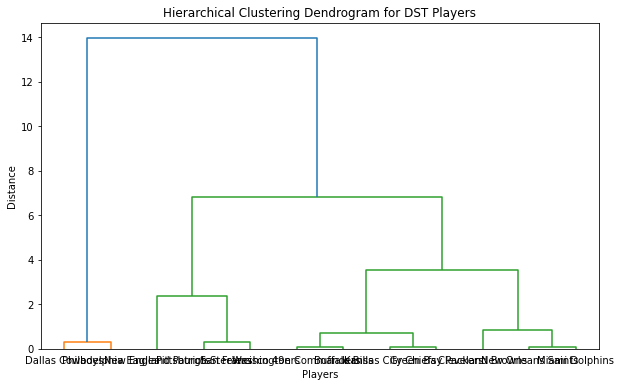

In [16]:
pos_df = df[df['Pos'] == 'DST']
pos_df.index = pos_df['pos_rank']
pos_df = pos_df[pos_df['pos_rank'] <= 12]
pos_df = pos_df.sort_index()
X = pos_df[['Projection']]
linkage_matrix = linkage(X, method='ward')
plt.figure(figsize=(10, 6))
dendrogram(linkage_matrix, labels=pos_df['Player'].tolist(), orientation='top', leaf_font_size=10)
plt.title('Hierarchical Clustering Dendrogram for DST Players')
plt.xlabel('Players')
plt.ylabel('Distance')
plt.show()

In [17]:
num_clusters = 3
clusters = fcluster(linkage_matrix, num_clusters, criterion='maxclust')

# Add a 'Cluster' column to the DataFrame
pos_df['Cluster'] = clusters

# find the cluster with the highest average projection and reorganize the clusters based on that
# Calculate the average projection for each cluster
cluster_avg_projections = pos_df.groupby('Cluster')['Projection'].mean().reset_index()

# Sort the clusters by average projection in descending order
cluster_avg_projections = cluster_avg_projections.sort_values(by='Projection', ascending=False)

# Create a dictionary to map old cluster numbers to new cluster numbers
new_cluster_numbers = {old_cluster: idx + 1 for idx, old_cluster in enumerate(cluster_avg_projections['Cluster'])}

# Update the 'Cluster' column with the new cluster numbers
pos_df['Cluster'] = pos_df['Cluster'].map(new_cluster_numbers)

# add cluster to df for each player
for player in pos_df['Player']:
    df.loc[df['Player'] == player, 'Cluster'] = pos_df.loc[pos_df['Player'] == player, 'Cluster'].values[0]
    
for cluster_num in range(1, num_clusters + 1):
    cluster_group = pos_df[pos_df['Cluster'] == cluster_num]
    print(f'Cluster {cluster_num}:')
    print(cluster_group[['Player', 'Projection']])
    print()


Cluster 1:
                       Player  Projection
pos_rank                                 
1.0            Dallas Cowboys       114.5
2.0       Philadelphia Eagles       114.2

Cluster 2:
                        Player  Projection
pos_rank                                  
3.0       New England Patriots       110.4
4.0        Pittsburgh Steelers       108.5
5.0        San Francisco 49ers       108.2

Cluster 3:
                         Player  Projection
pos_rank                                   
6.0            Cleveland Browns       107.3
7.0          New Orleans Saints       106.6
8.0              Miami Dolphins       106.5
9.0       Washington Commanders       105.2
10.0              Buffalo Bills       105.1
11.0         Kansas City Chiefs       104.7
12.0          Green Bay Packers       104.6



In [18]:
# drop players with no cluster
df = df.dropna(subset=['Cluster'])
df['Cluster'] = df['Cluster'].astype(int)
# sort by position rank
df = df.sort_values(by=['Pos', 'pos_rank'])
# write to csv
df.to_csv('2023_Draft.csv', index=False)